In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os

D:\miniconda\envs\oldPy\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\miniconda\envs\oldPy\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\miniconda\envs\oldPy\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\miniconda\envs\oldPy\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

In [2]:
env = gym.make('LunarLander-v2')
env = env.unwrapped

In [3]:
class PolicyGradient:   
    
    # first we define the __init__ method where we initialize all variables
    
    def __init__(self, n_x,n_y,learning_rate=0.01, reward_decay=0.95,load_path=None,save_path=None):
            
        # number of states in the environemnt    
        self.n_x = n_x 
        
        # number of actions in the environment
        self.n_y = n_y
        
        # learning rate of the network
        self.lr = learning_rate
        
        # discount factor
        self.gamma = reward_decay 
    
        # initialize the lists for storing observations, actions and rewards
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []
        
        self.save_path = None
        if save_path is not None:
            self.save_path = save_path
        
        # we define a function called build_network for building the neural network
        self.build_network()
        
        # stores the cost i.e loss
        self.cost_history = []
        
        # initialize tensorflow session
        self.sess = tf.Session()
        tf.summary.FileWriter("logs/", self.sess.graph)
        self.sess.run(tf.global_variables_initializer())
        
        self.saver = tf.train.Saver()
        if load_path is not None:
            self.load_path = load_path
            self.saver.restore(self.sess, os.path.join(os.getcwd(),self.load_path))
        

    # next we define a function called store_transition which stores the transition information
    # i.e state, action, reward and we can use this transitions for training the network

    def store_transition(self, s, a, r):
        
        self.episode_observations.append(s)
        self.episode_rewards.append(r)

        # store actions as list of arrays
        action = np.zeros(self.n_y)
        action[a] = 1
        self.episode_actions.append(action)
        
    # now, we define a function choose_action for choosing the action given the state,

    def choose_action(self, observation):

        # reshape observation to (num_features, 1)
        observation = observation[:, np.newaxis]

        # run forward propagation to get softmax probabilities
        prob_weights = self.sess.run(self.outputs_softmax, feed_dict = {self.X: observation})

        # select action using a biased sample this will return the index of the action we have sampled
        action = np.random.choice(range(len(prob_weights.ravel())), p=prob_weights.ravel())
        
        return action

    
    # we define build_network for creating our neural network
    
    def build_network(self):
        
        # placeholders for input x, and output y
        self.X = tf.placeholder(tf.float32, shape=(self.n_x, None), name="X")
        self.Y = tf.placeholder(tf.float32, shape=(self.n_y, None), name="Y")
        
        # placeholder for reward
        self.discounted_episode_rewards_norm = tf.placeholder(tf.float32, [None, ], name="actions_value")

        # we build 3 layer neural network with 2 hidden layers and 1 output layer
        
        # number of neurons in the hidden layer
        units_layer_1 = 10
        units_layer_2 = 10
        
        # number of neurons in the output layer
        units_output_layer = self.n_y
        
        # now let us initialize weights and bias value using tensorflow's tf.contrib.layers.xavier_initializer
        
        W1 = tf.get_variable("W1", [units_layer_1, self.n_x], initializer = tf.contrib.layers.xavier_initializer(seed=1))
        b1 = tf.get_variable("b1", [units_layer_1, 1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
        W2 = tf.get_variable("W2", [units_layer_2, units_layer_1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
        b2 = tf.get_variable("b2", [units_layer_2, 1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
        W3 = tf.get_variable("W3", [self.n_y, units_layer_2], initializer = tf.contrib.layers.xavier_initializer(seed=1))
        b3 = tf.get_variable("b3", [self.n_y, 1], initializer = tf.contrib.layers.xavier_initializer(seed=1))

        # and then, we perform forward propagation

        Z1 = tf.add(tf.matmul(W1,self.X), b1)
        A1 = tf.nn.relu(Z1)
        Z2 = tf.add(tf.matmul(W2, A1), b2)
        A2 = tf.nn.relu(Z2)
        Z3 = tf.add(tf.matmul(W3, A2), b3)
        A3 = tf.nn.softmax(Z3)


        # as we require, probabilities, we apply softmax activation function in the output layer,
        
        logits = tf.transpose(Z3)
        labels = tf.transpose(self.Y)
        self.outputs_softmax = tf.nn.softmax(logits, name='A3')

        # next we define our loss function as cross entropy loss
        neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
        
        # reward guided loss
        self.loss = tf.reduce_mean(neg_log_prob * self.discounted_episode_rewards_norm)  

        # we use adam optimizer for minimizing the loss
        self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)


    # define discount_and_norm_rewards function which will result the discounted and normalised reward
    
    def discount_and_norm_rewards(self):
        discounted_episode_rewards = np.zeros_like(self.episode_rewards)
        cumulative = 0
        for t in reversed(range(len(self.episode_rewards))):
            cumulative = cumulative * self.gamma + self.episode_rewards[t]
            discounted_episode_rewards[t] = cumulative

        discounted_episode_rewards -= np.mean(discounted_episode_rewards)
        discounted_episode_rewards /= np.std(discounted_episode_rewards)
        return discounted_episode_rewards
    
    # now we actually learn i.e train our network
    
    def learn(self):
        # discount and normalize episodic reward
        discounted_episode_rewards_norm = self.discount_and_norm_rewards()
        
        #modelPredicts = self.sess.run(self.outputs_softmax, feed_dict = {self.X: np.vstack(self.episode_observations).T})
        #actualResults = np.vstack(np.array(self.episode_actions))
        #ce = -actualResults*np.log(modelPredicts+1e-9)
        #ce = np.sum(ce,axis=1)
        #ceWithdiscRew = ce*discounted_episode_rewards_norm
        #meanCost = np.sum(ceWithdiscRew)/(len(ceWithdiscRew))
        
        # train the nework
        _, loss_val = self.sess.run([self.train_op,self.loss], feed_dict={
             self.X: np.vstack(self.episode_observations).T,
             self.Y: np.vstack(np.array(self.episode_actions)).T,
             self.discounted_episode_rewards_norm: discounted_episode_rewards_norm,
        })
        self.cost_history.append(loss_val)

        # reset the episodic data
        self.episode_observations, self.episode_actions, self.episode_rewards  = [], [], []
        
        if self.save_path is not None:
            save_path = self.saver.save(self.sess, os.path.join(os.getcwd(),self.save_path))
            print("Model saved in file: %s" % save_path)

        return discounted_episode_rewards_norm

In [4]:
load_version = 0
save_version = load_version + 1
#load_path = "output/weights/LunarLander/{}/LunarLander-v2.ckpt".format(load_version)
load_path=None
save_path = "output\{}\LunarLander-v2.ckpt".format(save_version)

In [5]:
policy = PolicyGradient(env.observation_space.shape[0],env.action_space.n,0.02,0.99,load_path,save_path)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.








In [6]:
RENDER_ENV = True
EPISODES = 5000
rewards = []
RENDER_REWARD_MIN = 5000

In [18]:
lastEpisode = episode

In [ ]:
for episode in range(lastEpisode,EPISODES):
    
    # get the state
    observation = env.reset()
    episode_reward = 0

    tic = time.clock()

    while True:
        
        if RENDER_ENV: env.render()

        # choose an action based on the state
        action = policy.choose_action(observation)

        # perform action in the environment and move to next state and receive reward
        observation_, reward, done, info = env.step(action)

        # store the transition information
        policy.store_transition(observation, action, reward)
        
        toc = time.clock()
        elapsed_sec = toc - tic
        if elapsed_sec > 120:
            done = True
            
        # sum the rewards obtained in each episode
        episode_rewards_sum = sum(policy.episode_rewards)
        
        # if the reward is less than -259 then terminate the episode
        if episode_rewards_sum < -250:
            done = True
    
        if done:
            episode_rewards_sum = sum(policy.episode_rewards)
            rewards.append(episode_rewards_sum)
            savedict = {"rewards":rewards,"losses":policy.cost_history}
            pickle.dump(savedict, open("savedict3.p", "wb" ) )   
            max_reward_so_far = np.amax(rewards)

            print("Episode: ", episode)
            print("Reward: ", episode_rewards_sum)
            print("Max reward so far: ", max_reward_so_far)

            # train the network
            discounted_episode_rewards_norm = policy.learn()

            if max_reward_so_far > RENDER_REWARD_MIN: RENDER_ENV = True


            break

        # update the next state as current state
        observation = observation_
        
    condition = np.mean(rewards[-100:])
    print("Average score is "+str(condition))
    if condition>185:
        break

In [101]:
import pickle
savedict = {"rewards":rewards,"losses":policy.cost_history}
pickle.dump(savedict, open("savedict2.p", "wb" ) )   

In [109]:
diction = pickle.load( open( "savedict4.p", "rb" ) )
rewardsSaved = diction['rewards']
lossesSaved = diction['losses']

Text(0.5, 1.0, 'Training progress for LunarLander-v2 policy gradient')

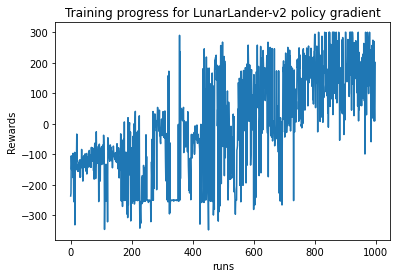

In [110]:
plt.plot(rewardsSaved)
plt.xlabel('runs')
plt.ylabel('Rewards')
plt.title("Training progress for LunarLander-v2 policy gradient")

Text(0.5, 1.0, 'Loss progress for LunarLander-v2 policy gradient')

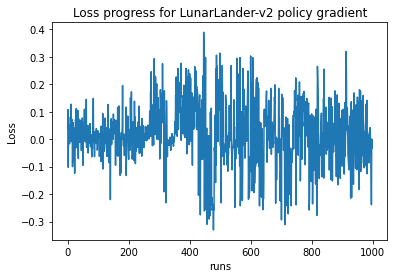

In [111]:
plt.plot(lossesSaved)
plt.xlabel('runs')
plt.ylabel('Loss')
plt.title("Loss progress for LunarLander-v2 policy gradient")